## Telecom Churn - ML Group Case Study (Ashish Veera and Deepak Kattil Veetil)
### Business Objective
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal.

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

In this project, we will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 

The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. 

**Derive new features**

This is one of the most important parts of data preparation since good features are often the differentiators between good and bad models. Use business understanding to derive features that could be important indicators of churn.

**High valued customers will be defined as below**
 - Customers with prepaid connection
 - Customers who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months
 
**The customers will tagged with Churn(1/0) based on the fourth month as follows** :
Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

    total_ic_mou_9
    total_og_mou_9
    vol_2g_mb_9
    vol_3g_mb_9

After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).


## Data Understanding

In [305]:
# Importing Pandas and NumPy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import ttest_ind, ttest_ind_from_stats
import scipy.stats
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

In [306]:
# Importing dataset
telecom = pd.read_csv("telecom_churn_data.csv")
print(telecom.shape)

(99999, 226)


#### Check for null values

In [307]:
(telecom.isnull().sum()*100)/len(telecom.index)

mobile_number                0.000000
circle_id                    0.000000
loc_og_t2o_mou               1.018010
std_og_t2o_mou               1.018010
loc_ic_t2o_mou               1.018010
last_date_of_month_6         0.000000
last_date_of_month_7         0.601006
last_date_of_month_8         1.100011
last_date_of_month_9         1.659017
arpu_6                       0.000000
arpu_7                       0.000000
arpu_8                       0.000000
arpu_9                       0.000000
onnet_mou_6                  3.937039
onnet_mou_7                  3.859039
onnet_mou_8                  5.378054
onnet_mou_9                  7.745077
offnet_mou_6                 3.937039
offnet_mou_7                 3.859039
offnet_mou_8                 5.378054
offnet_mou_9                 7.745077
roam_ic_mou_6                3.937039
roam_ic_mou_7                3.859039
roam_ic_mou_8                5.378054
roam_ic_mou_9                7.745077
roam_og_mou_6                3.937039
roam_og_mou_

In [308]:
# Check for null values within rows

telecom.isnull().all(axis=1).sum()

0

#### Handling Missing values

In [309]:
# Since the below features would be used in deriving the high value customers, we decided to impute the missing values
# with 0
cols = ['total_rech_data_6', 'total_rech_data_7','total_rech_data_8','av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']
for i in cols:
    telecom[i].fillna(0, inplace=True)

In [310]:
# Identify the columns having null values over 30%
df = round(100*(telecom.isnull().sum()/len(telecom.index)), 2).to_frame()
cols = df[df[0]>30].T.columns.tolist()
cols

['date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9',
 'total_rech_data_9',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'max_rech_data_9',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_2g_9',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'count_rech_3g_9',
 'av_rech_amt_data_9',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_3g_9',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'arpu_2g_9',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'night_pck_user_9',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'fb_user_9']

In [311]:
#remove the columns with null values over 30%
telecom=telecom.drop(cols, axis=1)
print(telecom.shape)
telecom.info()

(99999, 192)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 192 entries, mobile_number to sep_vbc_3g
dtypes: float64(149), int64(35), object(8)
memory usage: 146.5+ MB


In [312]:
# Check for null values after dropping the columns having null values greater than 30%
round(100*(telecom.isnull().sum()/len(telecom.index)), 2)

mobile_number           0.00
circle_id               0.00
loc_og_t2o_mou          1.02
std_og_t2o_mou          1.02
loc_ic_t2o_mou          1.02
last_date_of_month_6    0.00
last_date_of_month_7    0.60
last_date_of_month_8    1.10
last_date_of_month_9    1.66
arpu_6                  0.00
arpu_7                  0.00
arpu_8                  0.00
arpu_9                  0.00
onnet_mou_6             3.94
onnet_mou_7             3.86
onnet_mou_8             5.38
onnet_mou_9             7.75
offnet_mou_6            3.94
offnet_mou_7            3.86
offnet_mou_8            5.38
offnet_mou_9            7.75
roam_ic_mou_6           3.94
roam_ic_mou_7           3.86
roam_ic_mou_8           5.38
roam_ic_mou_9           7.75
roam_og_mou_6           3.94
roam_og_mou_7           3.86
roam_og_mou_8           5.38
roam_og_mou_9           7.75
loc_og_t2t_mou_6        3.94
loc_og_t2t_mou_7        3.86
loc_og_t2t_mou_8        5.38
loc_og_t2t_mou_9        7.75
loc_og_t2m_mou_6        3.94
loc_og_t2m_mou

In [313]:
# Remove all columns with a single unique value since it does not provide any variability
df = telecom.nunique().to_frame()
cols = df[df[0]==1].T.columns.tolist()
cols
print('Shape of the data set before dropping the columns with a single unique value', telecom.shape)
telecom.drop(cols, axis =1, inplace = True)
print('Shape of the data set after dropping the columns with a single unique value', telecom.shape)

Shape of the data set before dropping the columns with a single unique value (99999, 192)
Shape of the data set after dropping the columns with a single unique value (99999, 176)


#### Take day of month for date columns and dropping the date columns

In [314]:
print(telecom[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9']].info())

# Converting date values to datetype
telecom['date_of_last_rech_6'] = pd.to_datetime(telecom['date_of_last_rech_6'])
telecom['date_of_last_rech_7'] = pd.to_datetime(telecom['date_of_last_rech_7'])
telecom['date_of_last_rech_8'] = pd.to_datetime(telecom['date_of_last_rech_8'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 4 columns):
date_of_last_rech_6    98392 non-null object
date_of_last_rech_7    98232 non-null object
date_of_last_rech_8    96377 non-null object
date_of_last_rech_9    95239 non-null object
dtypes: object(4)
memory usage: 3.1+ MB
None


In [315]:
# Deriving the day value for each of the date columns
telecom['day_of_last_rech_6'] = telecom['date_of_last_rech_6'].apply(lambda x: x.day)
telecom['day_of_last_rech_7'] = telecom['date_of_last_rech_7'].apply(lambda x: x.day)
telecom['day_of_last_rech_8'] = telecom['date_of_last_rech_8'].apply(lambda x: x.day)

In [316]:
telecom[['day_of_last_rech_6','day_of_last_rech_7','day_of_last_rech_8']].head()


,day_of_last_rech_6,day_of_last_rech_7,day_of_last_rech_8
0,21.0,16.0,8.0
1,29.0,31.0,28.0
2,17.0,24.0,14.0
3,28.0,31.0,31.0
4,26.0,28.0,9.0


In [317]:
# Dropping the original date values
telecom.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9'], axis =1, inplace = True)
print(telecom.shape)

(99999, 175)


In [318]:
# Identifying all the features which have greater than or equal to 1 missing value and creating a list for those cols
df = round(100*(telecom.isnull().sum()/len(telecom.index)), 2).to_frame()
cols = df[df[0]>0].T.columns.tolist()
cols

['onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'onnet_mou_9',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'offnet_mou_9',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_ic_mou_9',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'roam_og_mou_9',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_t2c_mou_9',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'loc_og_mou_9',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_t2f_mou_9',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'std_og_mou_9',


In [319]:
# Imputing the missing values for continuous features with mean and integer values with median
for i in cols:
    if 'day_' not in i:
        telecom.loc[np.isnan(telecom[i]), [i]] = telecom[i].mean()
    else:
        telecom.loc[np.isnan(telecom[i]), [i]] = telecom[i].median()
    

In [320]:
# Checking for th existence of missing avlues after performing imputation
round(100*(telecom.isnull().sum()/len(telecom.index)), 2)

mobile_number         0.0
arpu_6                0.0
arpu_7                0.0
arpu_8                0.0
arpu_9                0.0
onnet_mou_6           0.0
onnet_mou_7           0.0
onnet_mou_8           0.0
onnet_mou_9           0.0
offnet_mou_6          0.0
offnet_mou_7          0.0
offnet_mou_8          0.0
offnet_mou_9          0.0
roam_ic_mou_6         0.0
roam_ic_mou_7         0.0
roam_ic_mou_8         0.0
roam_ic_mou_9         0.0
roam_og_mou_6         0.0
roam_og_mou_7         0.0
roam_og_mou_8         0.0
roam_og_mou_9         0.0
loc_og_t2t_mou_6      0.0
loc_og_t2t_mou_7      0.0
loc_og_t2t_mou_8      0.0
loc_og_t2t_mou_9      0.0
loc_og_t2m_mou_6      0.0
loc_og_t2m_mou_7      0.0
loc_og_t2m_mou_8      0.0
loc_og_t2m_mou_9      0.0
loc_og_t2f_mou_6      0.0
loc_og_t2f_mou_7      0.0
loc_og_t2f_mou_8      0.0
loc_og_t2f_mou_9      0.0
loc_og_t2c_mou_6      0.0
loc_og_t2c_mou_7      0.0
loc_og_t2c_mou_8      0.0
loc_og_t2c_mou_9      0.0
loc_og_mou_6          0.0
loc_og_mou_7

In [321]:
telecom.shape

(99999, 175)

### Deriving High value customers

In [322]:
# Calculating the total average recharge amount for data plus voice
telecom['avg_rech_amt_voc_data_6_7'] = ((telecom['total_rech_data_6']*telecom['av_rech_amt_data_6'])+
                                        (telecom['total_rech_data_7']*telecom['av_rech_amt_data_7'])+
                                        (telecom['total_rech_amt_6']+telecom['total_rech_amt_7']))/2

In [323]:
telecom[['total_rech_data_6', 'total_rech_data_7', 'av_rech_amt_data_6', 'av_rech_amt_data_7','total_rech_amt_6', 
         'total_rech_amt_7', 'avg_rech_amt_voc_data_6_7']].head()

,total_rech_data_6,total_rech_data_7,av_rech_amt_data_6,av_rech_amt_data_7,total_rech_amt_6,total_rech_amt_7,avg_rech_amt_voc_data_6_7
0,1.0,1.0,252.0,252.0,362,252,559.0
1,0.0,1.0,0.0,154.0,74,384,306.0
2,0.0,0.0,0.0,0.0,168,315,241.5
3,0.0,0.0,0.0,0.0,230,310,270.0
4,1.0,0.0,56.0,0.0,196,350,301.0


In [324]:
# Identifying the 70th percentile to obtain the High value customers
telecom.avg_rech_amt_voc_data_6_7.quantile(0.70)

478.0

In [325]:
# Subsetting the data set to obtain the High value customer based on total average recharge amount for data plus voice
# greater than 70th percentile which is 478.0
telecom = telecom[telecom['avg_rech_amt_voc_data_6_7']>=478.0]

In [326]:
print('Shape of the data set after deriving high value customers',telecom.shape)

Shape of the data set after deriving high value customers (30001, 176)


### Deriving the Churn (target variable)

In [327]:
#The customers will be tagged with Churn(1/0) based on the fourth month as follows** :
#Those who have not made any calls (either incoming or outgoing) 
#AND have not used mobile internet even once in the churn phase. 
telecom['churn'] = 0
telecom.loc[(telecom.total_ic_mou_9 == 0) & (telecom.total_og_mou_9 == 0) & (telecom.vol_2g_mb_9 == 0) & (telecom.vol_3g_mb_9 == 0),"churn"]=1

In [328]:
telecom.churn.value_counts()

0    27560
1     2441
Name: churn, dtype: int64

In [329]:
telecom.shape

(30001, 177)

After tagging churners, remove all the attributes corresponding to the churn phase i.e. all attributes having ‘ _9’, etc. in their names

In [330]:
cols = [c for c in telecom.columns if '_9' not in c]
cols

['mobile_number',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_

In [331]:
# Subsetting the telecom dataframe to drop the cols having their suffix as _9
telecom=telecom[cols]

# Also 'sep_vbc_3g belongs to the 9th month so dropping this column explicitly
telecom.drop('sep_vbc_3g',axis = 1, inplace = True)
print(telecom.shape)
telecom.head()

(30001, 136)


,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,day_of_last_rech_6,day_of_last_rech_7,day_of_last_rech_8,avg_rech_amt_voc_data_6_7,churn
0,7000842753,197.385,214.816,213.803,132.395875,133.670805,0.00,197.935577,197.045133,0.00,9.950013,7.149898,0.00,13.911337,9.818732,0.00,47.100763,46.47301,0.00,93.342088,91.397131,0.00,3.751013,3.792985,0.00,1.123056,1.3685,0.00,144.201175,141.670476,0.00,79.82987,83.299598,0.00,87.299624,90.804137,0.00,1.129011,1.11501,0.00,168.261218,175.221436,0.00,0.798277,0.776572,0.00,3.916811,4.978279,0.00,0.454157,0.030235,0.0,0.00,0.00,0.00,47.922365,47.99052,0.16,107.47565,107.120493,4.13,12.084305,12.599697,1.15,167.491059,167.71954,5.44,9.575993,10.011904,0.00,20.72224,21.656415,0.00,2.156397,2.216923,0.00,32.457179,33.887833,0.00,0.00,0.00,5.44,0.061557,0.033585,0.0,7.460608,8.334936,0.00,0.854656,1.01296,0.00,4,3,2,362,252,252,252,252,252,252,252,252,1.0,1.0,1.0,252.0,252.0,252.0,30.13,1.32,5.75,83.57,150.76,109.61,0,0,0,0,0,0,1,1,1,0,0,0,968,30.40,0.00,101.20,21.0,16.0,8.0,559.0,1
7,7000701601,1069.180,1349.850,3171.480,57.840000,54.680000,52.29,453.430000,567.160000,325.91,16.230000,33.490000,31.64,23.740000,12.590000,38.06,51.390000,31.38000,40.28,308.630000,447.380000,162.28,62.130000,55.140000,53.23,0.000000,0.0000,0.00,422.160000,533.910000,255.79,4.30000,23.290000,12.01,49.890000,31.760000,49.14,6.660000,20.08000,16.68,60.860000,75.140000,77.84,0.000000,0.180000,10.01,4.500000,0.000000,6.50,0.000000,0.000000,0.0,487.53,609.24,350.16,58.140000,32.26000,27.31,217.56000,221.490000,121.19,152.160000,101.460000,39.53,427.880000,355.23000,188.04,36.890000,11.830000,30.39,91.44000,126.990000,141.33,52.190000,34.240000,22.21,180.540000,173.080000,193.94,626.46,558.04,428.74,0.210000,0.000000,0.0,2.060000,14.530000,31.59,15.740000,15.19000,15.14,5,5,7,1580,790,3638,1580,790,1580,0,0,779,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,27.0,25.0,26.0,1185.0,1
8,7001524846,378.721,492.223,137.362,413.690000,351.030000,35.08,94.660000,80.630000,136.48,0.000000,0.000000,0.00,0.000000,0.000000,0.00,297.130000,217.59000,12.49,80.

#### Deriving new features

Deriving features  by taking the average of features from the action phase which is 6th and 7th month which is the 
action phase 

In [332]:
col_list = telecom.filter(regex='_6|_7').columns.str[:-2]
col_list.unique()

print (telecom.shape)

for idx, col in enumerate(col_list.unique()):
    if 'avg_' not in col:
        print(col)
        avg_col_name = "avg_"+col+"_av67"
        col_6 = col+"_6"
        col_7 = col+"_7"
        telecom[avg_col_name] = (telecom[col_6]  + telecom[col_7])/ 2

(30001, 136)
arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2t_mou
loc_og_t2m_mou
loc_og_t2f_mou
loc_og_t2c_mou
loc_og_mou
std_og_t2t_mou
std_og_t2m_mou
std_og_t2f_mou
std_og_mou
isd_og_mou
spl_og_mou
og_others
total_og_mou
loc_ic_t2t_mou
loc_ic_t2m_mou
loc_ic_t2f_mou
loc_ic_mou
std_ic_t2t_mou
std_ic_t2m_mou
std_ic_t2f_mou
std_ic_mou
total_ic_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
total_rech_amt
max_rech_amt
last_day_rch_amt
total_rech_data
av_rech_amt_data
vol_2g_mb
vol_3g_mb
monthly_2g
sachet_2g
monthly_3g
sachet_3g
day_of_last_rech


In [333]:
telecom.shape

(30001, 179)

In [334]:
# Dropping the columns having sufix as either _6 or _7 since we have derived the average values for the features
# in months 6 and 7 
col_list = telecom.filter(regex='_6|_7').columns

In [335]:
col_list

Index(['arpu_6', 'arpu_7', 'onnet_mou_6', 'onnet_mou_7', 'offnet_mou_6',
       'offnet_mou_7', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_og_mou_6',
       'roam_og_mou_7', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7',
       'loc_og_mou_6', 'loc_og_mou_7', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_mou_6', 'std_og_mou_7', 'isd_og_mou_6',
       'isd_og_mou_7', 'spl_og_mou_6', 'spl_og_mou_7', 'og_others_6',
       'og_others_7', 'total_og_mou_6', 'total_og_mou_7', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_mou_6', 'loc_ic_mou_7',
       'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_6',
       'std_ic_t2m_mou_7', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7',
      

In [336]:
telecom.drop(col_list, axis=1, inplace=True)
telecom.shape

(30001, 92)

## Exploratory Data Analysis

#### Welch's t-test assuming unequal variances to see if sample means are significantly different across two samples which is:
sample A = all records where churn=0  
sample B = all records where churn=1

In [337]:
# Creating a data frame to hold the first sample 'A' where Churned =0
telecom_not_churned = telecom.loc[telecom['churn']== 0,:]

In [338]:
# Creating a data frame to hold the second sample 'B' where Churned =1
telecom_churned = telecom.loc[telecom['churn']== 1,:]

In [339]:
# Defining the function for performing the t-test assuming unequal variances to see if two sample means are 
# significantly different and appending the insignificant feautres based on t-test results into a list to drop later
# from the telecom data set
insignificant_cols = []
def t_test(variable):
    for x in variable:
        if x != 'churn':
            two_sample_results = scipy.stats.ttest_ind(telecom_not_churned[x],telecom_churned[x], equal_var = False)
            if two_sample_results[1]>0.05:
                print(x,'and its p_value is', two_sample_results[1])
                insignificant_cols.append(x)

In [340]:
cols = telecom.columns.tolist()

In [341]:
# Fetures having their p-value greater than 0.05 which denotes these features donot have a significant difference
# in their means across two sample groups which is churned group and not churned group
t_test(cols)

isd_og_mou_8 and its p_value is 0.25145626911078445
og_others_8 and its p_value is 0.46981953736842197
avg_loc_og_t2c_mou_av67 and its p_value is 0.436360260234554
avg_og_others_av67 and its p_value is 0.0519158690151007
avg_std_ic_t2m_mou_av67 and its p_value is 0.9995763077384053
avg_std_ic_mou_av67 and its p_value is 0.2741220636631613
avg_spl_ic_mou_av67 and its p_value is 0.7486761440460529
avg_isd_ic_mou_av67 and its p_value is 0.8660047803925518
avg_max_rech_amt_av67 and its p_value is 0.13928313044334148
avg_sachet_3g_av67 and its p_value is 0.5016861461578173


In [342]:
insignificant_cols

['isd_og_mou_8',
 'og_others_8',
 'avg_loc_og_t2c_mou_av67',
 'avg_og_others_av67',
 'avg_std_ic_t2m_mou_av67',
 'avg_std_ic_mou_av67',
 'avg_spl_ic_mou_av67',
 'avg_isd_ic_mou_av67',
 'avg_max_rech_amt_av67',
 'avg_sachet_3g_av67']

In [343]:
telecom.shape

(30001, 92)

In [345]:
# Dropping these columns since these donot have a significant difference in means across two sample groups 
# which is churned group and not churned group and therefore will not provide any predictable power to the model
for i in insignificant_cols:
    telecom.drop(i,axis=1, inplace = True)
print(telecom.shape)

(30001, 82)


### Test for correlation  
The correlation test has been performed by looking at the correlation across the features in the good phase and then 
the same process was follwed by identifying the correlation among the features in the action phase

#### Test for correlation among the features in the good phase
Creating a list to contain the features from the good phase 

In [346]:
good_phase_features=[]
for cols in telecom.columns:
    if '_av67' in cols:
        good_phase_features.append(cols)
        

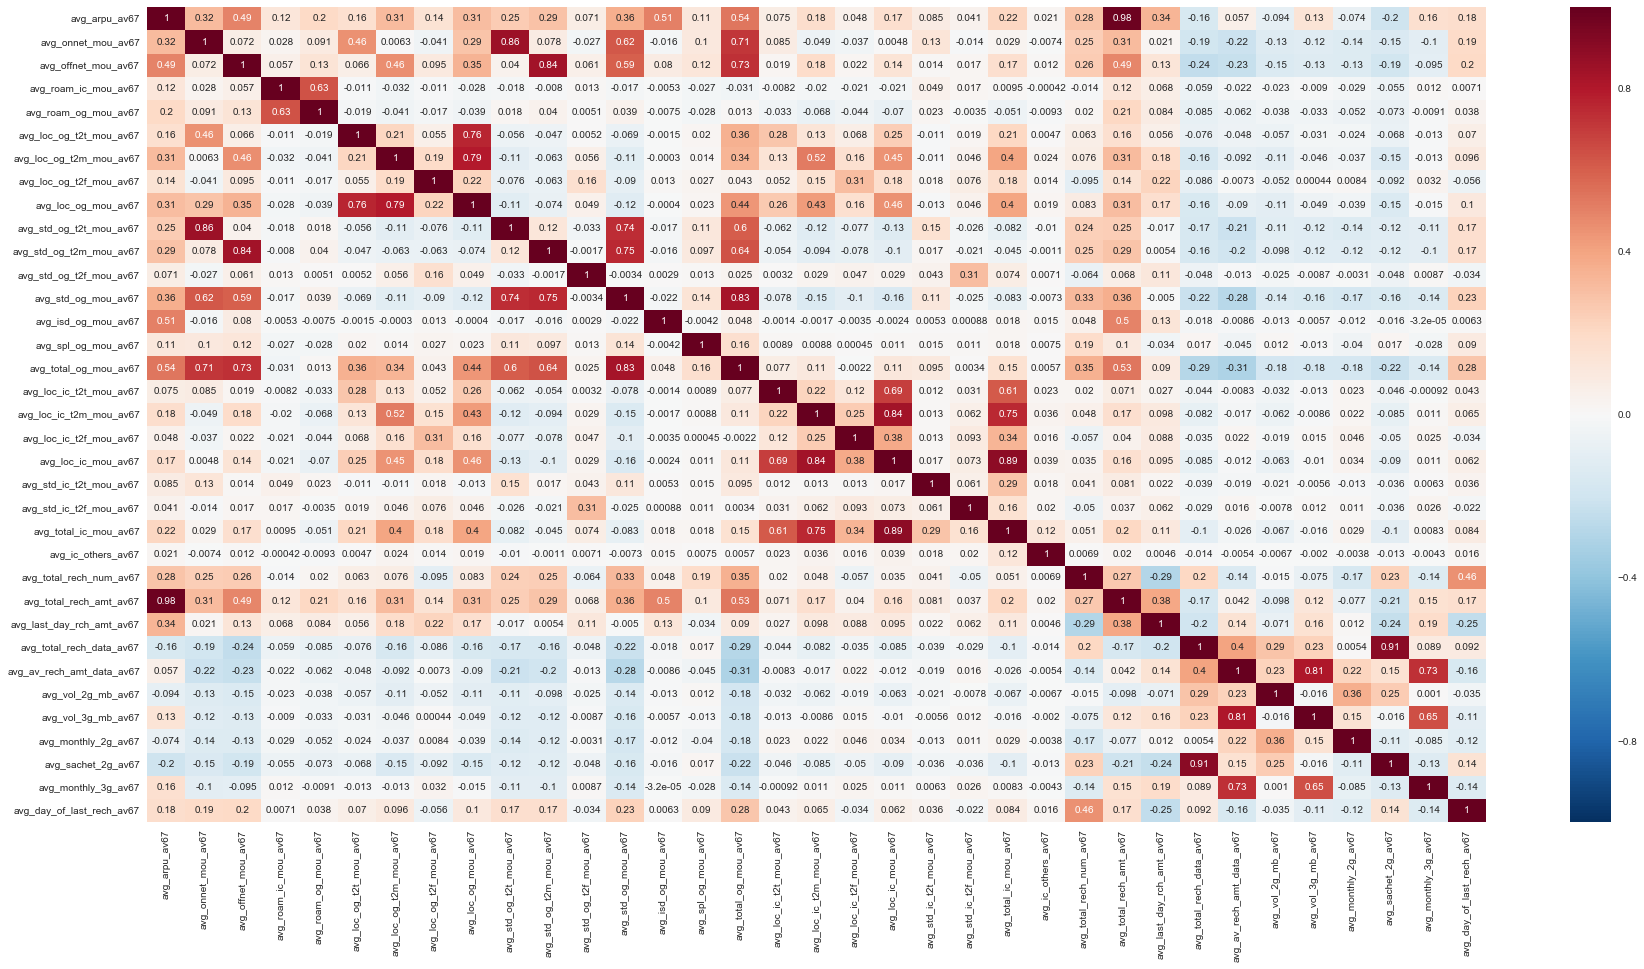

In [347]:
corr = telecom[good_phase_features].corr()
# Let's see the correlation matrix for good phase features
plt.figure(figsize = (30,15))        # Size of the figure
sns.heatmap(corr,annot = True)
plt.show()

In [348]:
# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)).T
# Find index of feature columns with correlation greater than 0.80
to_drop_good_phase = [index for index in upper.index if any(upper[index] > 0.80)]

In [349]:
to_drop_good_phase

['avg_arpu_av67',
 'avg_onnet_mou_av67',
 'avg_offnet_mou_av67',
 'avg_std_og_mou_av67',
 'avg_loc_ic_t2m_mou_av67',
 'avg_loc_ic_mou_av67',
 'avg_total_rech_data_av67',
 'avg_av_rech_amt_data_av67']

#### Test for correlation among the features in the action phase
Creating a list to contain the features from the action phase

In [350]:
action_phase_features=[]
for cols in telecom.columns:
    if '_8' in cols:
        action_phase_features.append(cols)

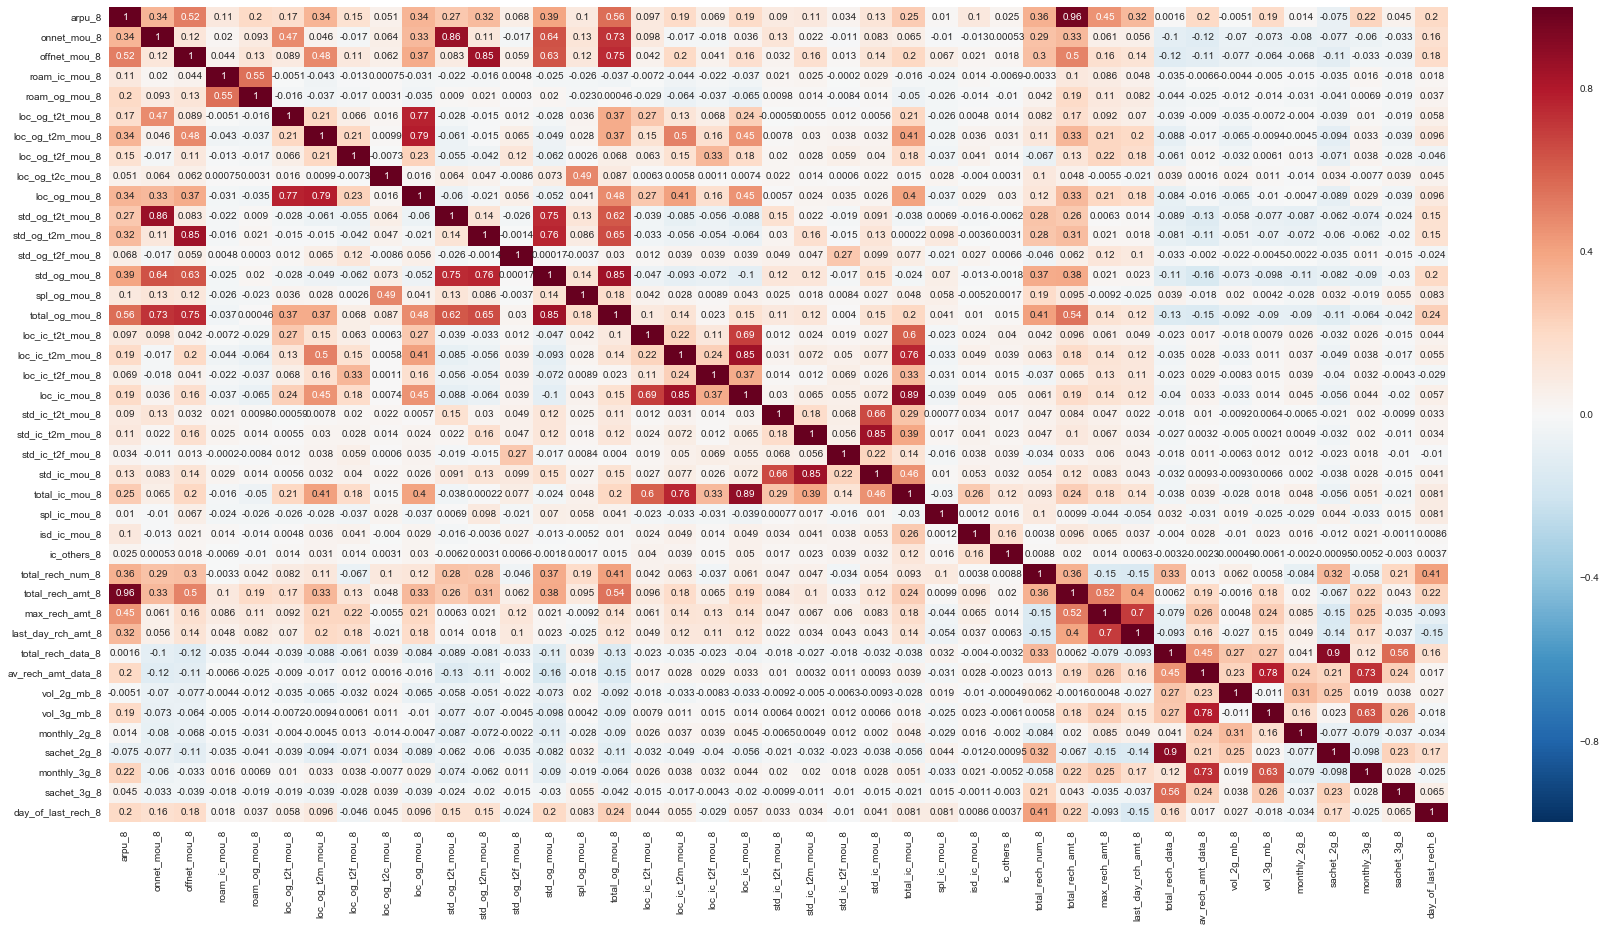

In [351]:
corr = telecom[action_phase_features].corr()
# Let's see the correlation matrix for the action phase features
plt.figure(figsize = (30,15))        # Size of the figure
sns.heatmap(corr,annot = True)
plt.show()

In [352]:
# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)).T
# Find index of feature columns with correlation greater than 0.80
to_drop_action_phase = [index for index in upper.index if any(upper[index] > 0.80)]

In [353]:
to_drop_action_phase

['arpu_8',
 'onnet_mou_8',
 'offnet_mou_8',
 'std_og_mou_8',
 'loc_ic_t2m_mou_8',
 'loc_ic_mou_8',
 'std_ic_t2m_mou_8',
 'total_rech_data_8']

In [354]:
telecom.shape

(30001, 82)

Dropping the correlation features identified in the previous steps

In [355]:
telecom.drop(to_drop_good_phase, axis =1, inplace = True)
telecom.drop(to_drop_action_phase, axis =1, inplace = True)
print(telecom.shape)

(30001, 66)


#### Correlation between Churn and other features

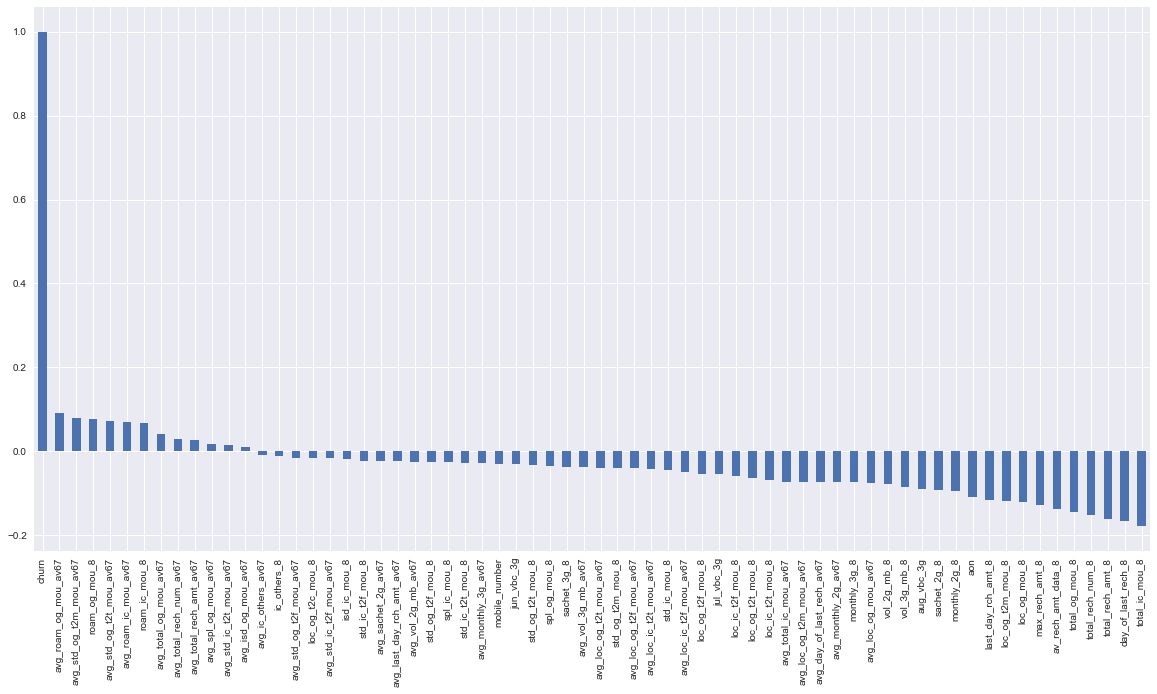

In [356]:
plt.figure(figsize=(20,10))
telecom.corr()['churn'].sort_values(ascending = False).plot(kind='bar')
plt.show()

Observations:  
    The feature total_ic_mou_8 is highly negatively correlated with Churn   
    The feature avg_roam_og_mou_av67 is highly positively correlated with Churn

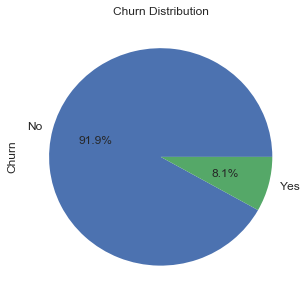

In [357]:
#Churn Distribution
trgt = (telecom['churn'].value_counts()*100.0 /len(telecom)).plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           

trgt.set_ylabel('Churn',fontsize = 12)
trgt.set_title('Churn Distribution', fontsize = 12)
plt.show()

Observation:  
    We can see that the dataset is highly imbalanced with 91.9% of records tagged as 0 i.e. not Churn and only 8.1% of the records tagged as 1 i.e. Churn  
    This will be handled during the model building phase by applying the SMOTE (Synthetic Minority Oversampling Technique) 

#### Univariate Analysis

In [451]:
def plot_continuous_chart(axe, title, plottype, col, df, log):
    axe.set_title(title)
    if log==True:
        axe.set_yscale('log')
    if (plottype=='d'):   
        sns.distplot(df[col],ax=axe)
    else: 
        sns.boxplot(data =df, x=col,ax=axe,orient='v')
        
def plot_univariate(vtype,col,hue =None,log=False,vertlabel=False, flipvertical=False):
    if vtype == 'continuous':
        fig, ax=plt.subplots(nrows =1,ncols=4,figsize=(15,5))
        plot_continuous_chart(ax[0], "Box Plot", 'b', col, telecom, log)
        plot_continuous_chart(ax[1], "Distribution Plot", 'd', col, telecom, log)
        plot_continuous_chart(ax[2], "Box Plot for churn", 'b', col, telecom[telecom.churn == 1], log)
        plot_continuous_chart(ax[3], "Box Plot for no churn", 'b', col, telecom[telecom.churn == 0], log)
    else:
        fig, ax = plt.subplots()
        hue_col = pd.Series(data = hue)
        width = len(telecom[col].unique()) + 4 + 2*len(hue_col.unique())
        if flipvertical==True:
            fig.set_size_inches(6 , 8)
            ax = sns.countplot(data = telecom, y= col, order=telecom[col].value_counts().index,hue = hue) 
        else:
            fig.set_size_inches(width , 12)
            ax = sns.countplot(data = telecom, x= col, order=telecom[col].value_counts().index,hue = hue) 
            for p in  ax.patches:
                if (p.get_height() > 0):
                    ax.annotate('{:1.2f}%'.format((p.get_height()*100)/float(len(telecom))), (p.get_x()+0.05, p.get_height()+20))  
    if (vertlabel== True): 
        plt.xticks(rotation=90)
    plt.show() 

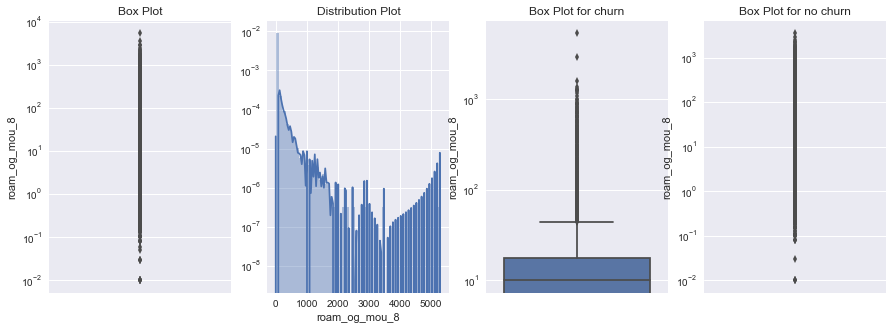

In [458]:
plot_univariate(vtype = 'continuous', col='roam_og_mou_8', log=True)

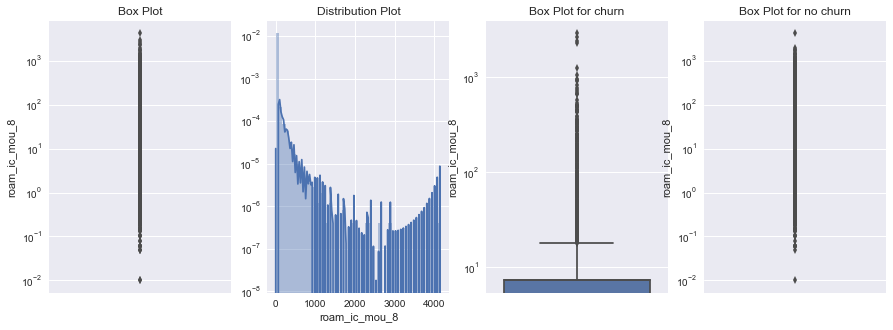

In [453]:
plot_univariate(vtype = 'continuous', col='roam_ic_mou_8', log=True)

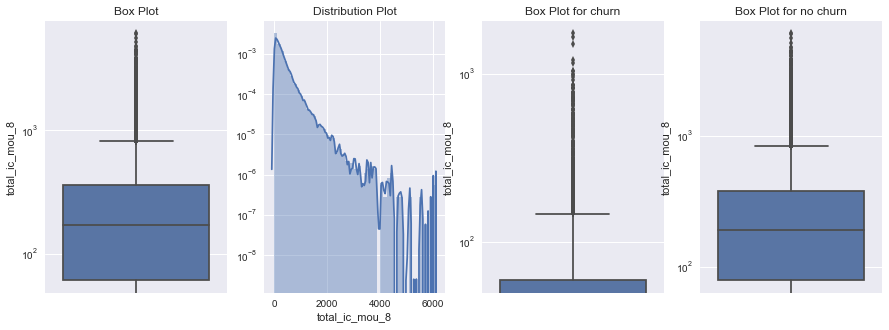

In [454]:
plot_univariate(vtype = 'continuous', col='total_ic_mou_8', log=True)

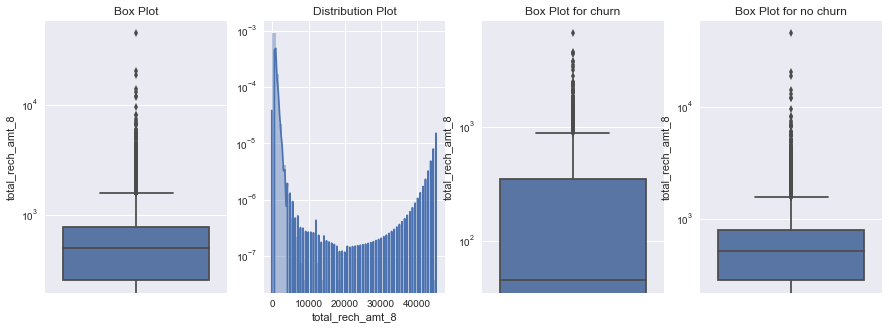

In [455]:
plot_univariate(vtype = 'continuous', col='total_rech_amt_8', log=True)

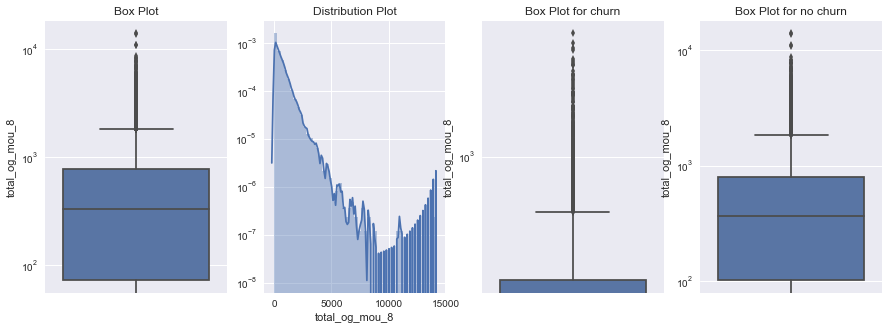

In [456]:
plot_univariate(vtype = 'continuous', col='total_og_mou_8', log=True)

Basing on our EDA, the customers having more usage interms of incoming and outgoing didnot churn. But the customers having 
more Roaming incoming and outgoing had more churn 

## Model Building

## Train - Test Split

In [358]:
from sklearn.model_selection import train_test_split
# Putting feature variable to X
X = telecom.drop(['churn','mobile_number'],axis=1)
# Putting response variable to y
y = telecom['churn']

In [359]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [360]:
X_train.shape

(21000, 64)

In [361]:
y_train.value_counts()

0    19309
1     1691
Name: churn, dtype: int64

#### SMOTE - Handling the imbalance in the dataset by applying SMOTE (Synthetic Minority Oversampling technique)

In [362]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(kind = "regular")
X_tr,y_tr = sm.fit_sample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

(38618, 64)
(38618,)


In [363]:
pd.Series(y_tr).value_counts()

1    19309
0    19309
dtype: int64

Observation: As seen above the value counts for churn and not churn are equal making the training set a balanced dataset

### Applying a Random Forest Model

In [367]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model_rf = RandomForestClassifier()
model_rf.fit(X_tr, y_tr)

# Make predictions
prediction_test = model_rf.predict(X_test)
print ('Random Forest Accuracy with Default Hyperparameter on the test set',metrics.accuracy_score(y_test, prediction_test))
print('Random Forest AUC with Default Hyperparameter on the test set',metrics.roc_auc_score(y_test, prediction_test))

Random Forest Accuracy with Default Hyperparameter on the test set 0.9371180979891123
Random Forest AUC with Default Hyperparameter on the test set 0.7856989455823536


#### Hyperparameter Tuning

Tuning max_depth

In [368]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="roc_auc", return_train_score=True)
rf.fit(X_tr, y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [369]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.401247,0.012043,0.942513,0.942870,2,{'max_depth': 2},4,0.940061,0.955001,0.934935,0.935437,0.942976,0.936665,0.949441,0.943366,0.945153,0.943883,0.109138,0.005296,0.004871,0.006960
1,0.862667,0.013264,0.973256,0.977637,7,{'max_depth': 7},3,0.961668,0.981558,0.974121,0.977214,0.978089,0.975110,0.976836,0.976605,0.975567,0.977695,0.195048,0.002248,0.005942,0.002145
2,1.091272,0.013369,0.985752,0.995541,12,{'max_depth': 12},2,0.975362,0.996685,0.986747,0.995103,0.990256,0.995198,0.989167,0.995632,0.987231,0.995086,0.022400,0.001019,0.005350,0.000605
3,1.279291,0.014479,0.989501,0.999336,17,{'max_depth': 17},1,0.978706,0.999374,0.991826,0.999467,0.992717,0.999455,0.992405,0.999111,0.991852,0.999273,0.029625,0.001640,0.005408,0.000132


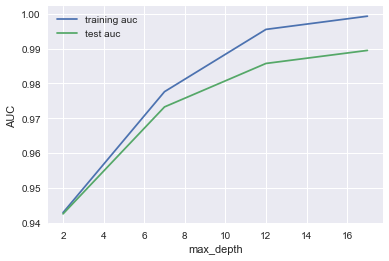

In [370]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training auc")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test auc")
plt.xlabel("max_depth")
plt.ylabel("AUC")
plt.legend()
plt.show()

Tuning min_samples_leaf

In [371]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(50, 400, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="roc_auc", return_train_score=True)
rf.fit(X_tr, y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [372]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_min_samples_leaf,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.039954,0.014531,0.976782,0.981558,50,{'min_samples_leaf': 50},1,0.964555,0.985088,0.977737,0.980630,0.981483,0.979765,0.980516,0.980872,0.979622,0.981435,0.042459,0.002021,0.006237,0.001845
1,1.359690,0.019539,0.971915,0.975740,100,{'min_samples_leaf': 100},2,0.957017,0.978957,0.973563,0.974796,0.977709,0.974502,0.975610,0.974597,0.975680,0.975850,0.414332,0.010894,0.007564,0.001679
2,1.275177,0.012858,0.969176,0.972251,150,{'min_samples_leaf': 150},3,0.955381,0.977230,0.970530,0.971696,0.974782,0.970398,0.973489,0.970660,0.971698,0.971273,0.485790,0.001023,0.007050,0.002530
3,0.896006,0.011672,0.966869,0.969238,200,{'min_samples_leaf': 200},4,0.953317,0.973649,0.967806,0.968985,0.972419,0.966841,0.972302,0.968227,0.968501,0.968489,0.240900,0.000886,0.007036,0.002317
4,1.266703,0.043016,0.965728,0.968029,250,{'min_samples_leaf': 250},5,0.951530,0.971110,0.966428,0.967631,0.972612,0.967263,0.970351,0.967109,0.967721,0.967031,0.367518,0.031587,0.007414,0.001554


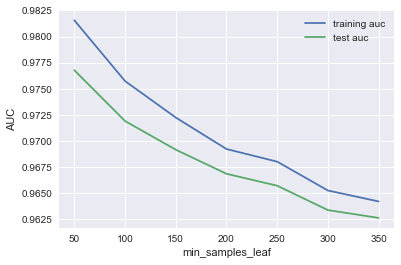

In [373]:
# plotting auc's with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training auc")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test auc")
plt.xlabel("min_samples_leaf")
plt.ylabel("AUC")
plt.legend()
plt.show()

Tuning min_samples_split

In [374]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(300, 800, 100)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="roc_auc", return_train_score=True)
rf.fit(X_tr, y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

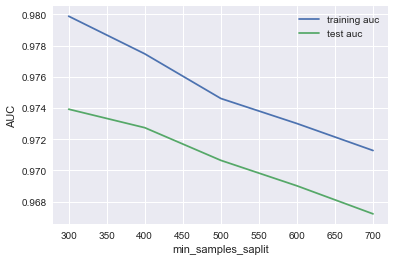

In [375]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training auc")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test auc")
plt.xlabel("min_samples_saplit")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [376]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(300, 700, 200),
    'n_estimators': [100,200], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1, scoring = 'roc_auc')

In [377]:
grid_search.fit(X_tr, y_tr)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  7.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [379]:
# printing the optimal accuracy score and hyperparameters
print('We can get an auc of',grid_search.best_score_,'using',grid_search.best_params_)

We can get an auc of 0.9709730195943963 using {'max_depth': 8, 'max_features': 10, 'min_samples_leaf': 100, 'min_samples_split': 300, 'n_estimators': 100}


In [380]:
# Fitting the RandomForestClassifier using the best parameters obtained by Grid Search CV on the train set
from sklearn.ensemble import RandomForestClassifier
m1= RandomForestClassifier(n_estimators=100,max_depth=8, min_samples_leaf=100,min_samples_split=300, max_features=10, n_jobs=-1)
m1.fit(X_tr,y_tr)
m1.score(X_test,y_test)

0.9137873569603377

In [381]:
#Predicting probabilities on the balanced training data set, imbalanced training data set and tst set
y_trprob = m1.predict_proba(X_tr)[:,1]
y_trainprob = m1.predict_proba(X_train)[:,1]
y_testprob = m1.predict_proba(X_test)[:,1]

In [382]:
# Creating a data frame to hold the ground truth 'churn' and the predicted probability for the balanced training dataset
y_tr_pred_final = pd.DataFrame(list(zip(y_tr.tolist(), y_trprob.tolist())),
              columns=['churn','churn_prob'])

In [383]:
# Creating a data frame to hold the ground truth 'churn' and the predicted probability for the imbalanced training dataset
y_train_pred_final = pd.DataFrame(list(zip(y_train.tolist(), y_trainprob.tolist())),
              columns=['churn','churn_prob'])

In [384]:
# Creating a data frame to hold the ground truth 'churn' and the predicted probability for the testing dataset
y_test_pred_final = pd.DataFrame(list(zip(y_test.tolist(), y_testprob.tolist())),
              columns=['churn','churn_prob'])

In [385]:
# Defining a function to plot the ROC-AUC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

#### ROC_AUC curve obtained by fitting the RF calssifier on the balanced training dataset

In [386]:
fpr, tpr, thresholds = metrics.roc_curve( y_tr_pred_final.churn, y_tr_pred_final.churn_prob, drop_intermediate = False )

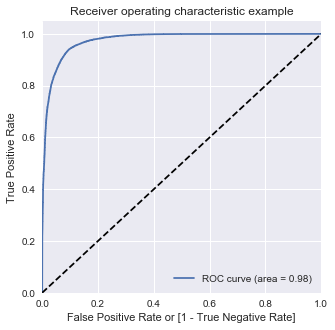

In [387]:
draw_roc(y_tr_pred_final.churn, y_tr_pred_final.churn_prob)

#### ROC_AUC curve obtained by fitting the RF calssifier on the imbalanced training dataset

In [388]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.churn, y_train_pred_final.churn_prob, drop_intermediate = False )

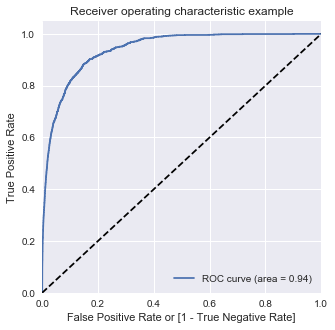

In [389]:
draw_roc(y_train_pred_final.churn, y_train_pred_final.churn_prob)

#### ROC_AUC curve obtained by fitting the RF calssifier on the testing dataset

In [390]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_pred_final.churn, y_test_pred_final.churn_prob, drop_intermediate = False )

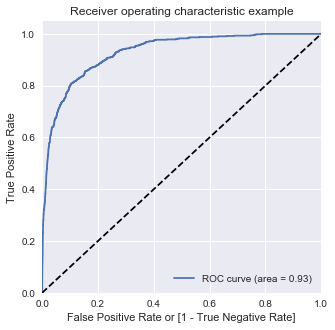

In [391]:
draw_roc(y_test_pred_final.churn, y_test_pred_final.churn_prob)

#### Precision, Recall , Accuracy and Specificity on the test set across various probability threshold values

In [392]:
# Let's create columns with different probability cutoffs on the test set
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_test_pred_final[i]= y_test_pred_final.churn_prob.map(lambda x: 1 if x > i else 0)
y_test_pred_final.head()

,churn,churn_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.230155,1,1,1,0,0,0,0,0,0,0
1,1,0.856143,1,1,1,1,1,1,1,1,1,0
2,0,0.112467,1,1,0,0,0,0,0,0,0,0
3,0,0.043033,1,0,0,0,0,0,0,0,0,0
4,1,0.848998,1,1,1,1,1,1,1,1,1,0


In [393]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci', 'preci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_test_pred_final.churn, y_test_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    preci = cm1[1,1]/(cm1[1,1]+cm1[0,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci, preci]
print(cutoff_df)

     prob  accuracy     sensi     speci     preci
0.0   0.0  0.083324  1.000000  0.000000  0.083324
0.1   0.1  0.615376  0.977333  0.582475  0.175443
0.2   0.2  0.754361  0.921333  0.739183  0.243053
0.3   0.3  0.829686  0.868000  0.826203  0.312230
0.4   0.4  0.880680  0.816000  0.886559  0.395349
0.5   0.5  0.913787  0.737333  0.929827  0.488516
0.6   0.6  0.928675  0.676000  0.951642  0.559603
0.7   0.7  0.938229  0.633333  0.965944  0.628307
0.8   0.8  0.942229  0.550667  0.977821  0.692953
0.9   0.9  0.938229  0.385333  0.988486  0.752604


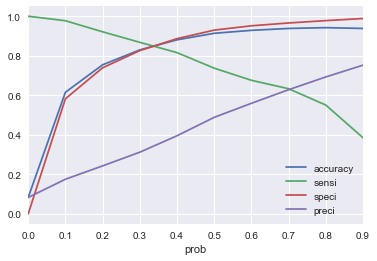

In [394]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci', 'preci'])
plt.show()

#### Observations: By looking at the above metrics at various thresholds we can choose a threshold value basing on the business objective i.e.     
1) If the business objective is to identify maximum churn we can use a lower threshold value which could be 0.4 which give a recall value of 81% with a 39% precision.  
2) If the business objective is to maximise the precision than we can use a higher threshold value which could be 0.7 which give a precision of 63% with a recall value of 63%

### Identifying the most important features for predicting churn

In [395]:
feature_importances = pd.DataFrame(m1.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(5)

,importance
roam_og_mou_8,0.237984
roam_ic_mou_8,0.174912
day_of_last_rech_8,0.087134
total_ic_mou_8,0.077690
total_rech_amt_8,0.062790


Observation: Based on the feature importances obtained using the Random Forest algorithm roam_og_mou_8, roam_ic_mou_8, total_ic_mou_8, day_of_last_rech_8, total_rech_amt_8 are important predictors to predict Churn.  

#### Our Recommendation:

The telecom company should provide better offers for customers that are frequently on Roaming. Also based on our EDA, Roaming seems to have a postive correlation on Churn so definitely the telecom company needs to 
provide better offers for Roaming customer to avoid Churn

### PCA Analysis

## Feature Scaling

In [396]:
from sklearn.preprocessing import StandardScaler

In [397]:
X_tr=pd.DataFrame(data=X_tr,columns=X_train.columns)

In [398]:
scaler = StandardScaler()

X_tr[X_train.columns] = scaler.fit_transform(X_tr[X_train.columns])

X_tr.head()

,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,spl_og_mou_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,day_of_last_rech_8,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_total_og_mou_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2f_mou_av67,avg_total_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_day_of_last_rech_av67
0,0.121288,-0.174321,-0.291351,-0.489057,-0.292040,-0.071739,-0.506356,-0.372047,-0.355113,-0.136975,-0.285933,-0.474012,-0.005842,-0.261584,-0.200070,-0.123090,0.203532,0.294954,-0.220632,0.932970,-0.095767,-0.554510,0.411335,0.654614,1.011055,-0.473381,-0.264181,-0.295676,-0.285426,-0.345735,-0.281724,-0.155931,2.994909,-0.316095,-0.355166,-0.357526,0.668644,0.088696,-0.198786,-0.339781,-0.527035,-0.203097,-0.570151,-0.490124,-0.498492,-0.166668,2.573114,-0.165372,-0.722580,-0.232610,-0.102795,-0.231738,-0.149298,0.466432,-0.008694,-0.679134,1.057455,1.090875,-0.408058,-0.385101,-0.407679,-0.485746,-0.382873,-1.056463
1,-0.192836,-0.263903,-0.088540,0.551285,2.009846,-0.250023,0.402598,-0.372047,-0.337375,-0.136975,-0.355447,-0.132185,-0.082915,0.087222,-0.200070,-0.123090,-0.117895,0.474132,-0.220632,-0.058375,-0.079062,-0.319987,0.114222,0.050561,0.486507,0.112451,1.138106,-0.072901,-0.285426,0.156430,-0.281724,-0.155931,1.500576,0.230640,0.038825,0.413272,1.038502,-0.222584,-0.290132,-0.119943,0.426817,0.157605,0.227046,-0.375169,-0.456387,0.178919,-0.063005,0.092333,-0.405291,-0.238823,1.728908,-0.002367,1.161933,0.395939,0.270947,-0.558697,-0.372333,0.083637,-0.121715,-0.068225,-0.407679,0.656382,-0.382873,-0.113597
2,0.497914,0.432853,-0.168658,0.094294,-0.292040,-0.250023,-0.058345,-0.294372,-0.279748,-0.136975,-0.355447,-0.270462,-0.000949,-0.184273,0.394473,-0.123090,0.313316,0.390060,-0.220632,0.095478,1.099567,0.266321,-0.109486,0.050561,-0.262847,-0.473381,-0.264181,-0.295676,-0.285426,-0.345735,-0.281724,-0.155931,2.580071,-0.316095,-0.355166,-0.357526,-0.440931,0.113265,-0.092744,-0.285342,0.360175,-0.003626,0.072744,-0.369357,-0.337925,-0.166668,-0.061053,-0.442179,-0.412227,-0.256856,-0.336968,-0.099331,-0.149298,-0.209034,-0.096110,-0.438260,-0.613686,-0.578901,-0.407629,-0.385101,-0.407679,0.656382,-0.382873,0.829269
3,0.037481,-0.049852,3.265342,1.346828,0.971532,0.135718,2.913532,-0.272437,0.016566,3.137317,0.574152,1.348117,9.549123,1.167162,-0.200070,0.201369,-0.143314,4.394214,-0.220632,-0.171215,-0.095767,0.266321,0.397353,0.050561,0.486507,-0.473381,-0.264181,-0.295676,-0.285426,-0.345735,-0.281724,-0.155931,0.488692,-0.316095,-0.355166,-0.357526,0.668644,-0.000065,-0.140888,-0.176145,0.331519,0.296698,0.139478,2.363851,-0.328593,-0.166668,-0.063005,0.591879,1.359720,-0.185027,0.927789,-0.229726,-0.079374,2.513728,-0.096110,-0.076950,0.280441,-0.355070,-0.408058,-0.385101,-0.407679,-0.485746,-0.382873,0.829269
4,-0.192836,-0.263903,-0.250812,-0.172912,-0.053454,-0.250023,-0.267061,-0.338072,-0.394120,-0.136975,-0.260655,-0.451522,1.547844,1.393660,-0.200070,-0.123090,-0.320883,1.056569,-0.220632,-0.171215,1.144114,-0.202725,-0.207358,0.196998,-0.262847,0.447212,-0.026054,0.214321,2.841869,-0.345735,-0.281724,-0.155931,-0.869271,0.464284,0.730632,-0.017606,1.038502,-0.222584,-0.290

In [399]:
X_test = scaler.transform(X_test)

In [400]:
X_test

array([[-0.19283622, -0.2639029 , -0.27354111, ..., -0.48574635,
        -0.38287308,  0.5598784 ],
       [-0.15870762, -0.21793097, -0.30237687, ...,  2.02693654,
        -0.38287308,  0.69457354],
       [-0.19283622, -0.2639029 ,  0.58078901, ..., -0.48574635,
         0.61002286,  0.02109785],
       ...,
       [-0.19283622, -0.2639029 ,  0.04274762, ..., -0.48574635,
        -0.38287308, -0.78707297],
       [-0.19283622, -0.2639029 , -0.31871713, ...,  1.11323367,
        -0.38287308,  0.42518326],
       [-0.19283622, -0.2639029 , -0.2729757 , ..., -0.48574635,
        -0.38287308,  0.96396381]])

In [401]:
X_test = pd.DataFrame(data = X_test,columns= X_train.columns)

In [402]:
X_test.head()

,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,spl_og_mou_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,day_of_last_rech_8,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_total_og_mou_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2f_mou_av67,avg_total_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_day_of_last_rech_av67
0,-0.192836,-0.263903,-0.273541,-0.520634,-0.179412,-0.250023,-0.509719,-0.372047,-0.377235,-0.033120,-0.160175,-0.569587,-0.360376,0.365965,-0.200070,-0.123090,-0.287720,-0.421825,-0.220632,-0.171215,-0.095767,-0.437248,-0.210853,0.135982,0.591416,-0.473381,-0.264181,-0.295676,-0.285426,-0.345735,-0.281724,-0.155931,-0.424639,-0.316095,-0.355166,-0.357526,-2.660081,-0.222584,-0.290132,-0.355976,-0.533681,-0.115884,-0.578057,-0.473184,-0.498391,-0.116716,-0.063005,-0.290987,-0.873714,-0.372707,-0.000734,-0.011653,0.032503,-0.517072,-0.096110,-0.076950,0.124630,-0.041708,-0.408058,-0.385101,-0.407679,-0.485746,-0.382873,0.559878
1,-0.158708,-0.217931,-0.302377,-0.596103,-0.292040,0.192445,-0.581521,-0.365612,-0.394120,-0.136975,-0.182925,-0.610492,-0.334767,-0.327419,0.095276,-0.123090,-0.174109,-0.508747,-0.220632,-0.171215,-0.095767,-0.085464,-0.598847,-0.559594,-0.487653,-0.025041,0.458268,-0.295676,-0.285426,0.658594,-0.281724,0.993035,-0.351297,-0.316095,-0.355166,-0.357526,0.113856,-0.190348,-0.227023,-0.350284,-0.637886,-0.229708,-0.652808,-0.476528,-0.513228,-0.166668,-0.063005,0.619721,-0.899876,-0.160478,-0.337107,-0.203801,-0.149298,-0.642010,-0.096110,-0.137169,-1.029180,-0.708723,0.461859,-0.385101,-0.407679,2.026937,-0.382873,0.694574
2,-0.192836,-0.263903,0.580789,2.923049,-0.119432,1.377221,2.217870,-0.161102,0.195066,0.936956,0.339067,1.149139,-0.126549,0.101114,-0.019856,0.537325,0.112880,0.935184,-0.220632,-0.166613,-0.087415,0.031798,0.594845,0.288521,0.486507,-0.473381,-0.264181,-0.295676,-0.285426,-0.345735,-0.281724,-0.155931,-0.926570,-0.316095,-0.325715,-0.107246,0.483715,-0.222584,-0.290132,0.898299,2.763011,-0.150322,2.379588,-0.375849,-0.339704,0.159040,-0.063005,0.035353,0.651121,0.133316,-0.103210,-0.096855,0.114747,0.699630,-0.054794,-0.257605,0.424031,0.482056,-0.404305,1.083447,-0.407679,-0.485746,0.610023,0.021098
3,-0.192836,-0.263903,0.329579,0.271600,-0.292040,-0.250023,0.360473,-0.369244,-0.209883,-0.136975,-0.355447,-0.080596,-0.187881,-0.266114,-0.173487,-0.087323,-0.268678,0.036211,-0.220632,-0.171215,-0.095767,1.790721,0.152672,-0.437563,-0.262847,-0.473381,-0.264181,-0.295676,-0.285426,-0.345735,-0.281724,-0.155931,0.199910,-0.316095,-0.355166,-0.343903,1.038502,-0.222584,-0.290132,-0.079428,0.303759,-0.093299,0.150537,-0.450664,-0.285525,-0.166668,-0.063005,-0.234007,-0.389338,0.040121,-0.109996,-0.061490,0.087110,0.382174,-0.096110,0.946761,-0.259294,-0.668433,-0.408058,-0.385101,-0.407679,-0.485746,-0.382873,1.098659
4,0.153902,0.097967,-0.318717,-0.582647,-0.292040,-0.250023,-0.582978,-0.342647,-0.394120,-0.136975,-0.355447,-0.602648,-0.379624,-0.327419,-0.200070,-0.123090,-0.320883,-0.482335,-0.220632,0.034657,-0.095767,-0.671772,-0.546415,-0.071470,-0.487653,-0.473381,-0.264181,-0.295676,-0.285426,-0.345735,-0.281724,-0.155931,0.603288,-0.260260,4.129671,2.889

### Applying PCA on the data

#### Note - 
- While computng the principal components, we must not include the entire dataset. Model building is all about doing well on the data we haven't seen yet!
- So we'll calculate the PCs using the train data, and apply them later on the test data

In [403]:
X_tr.shape

(38618, 64)

In [404]:
X_tr.head()

,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,spl_og_mou_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,day_of_last_rech_8,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_total_og_mou_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2f_mou_av67,avg_total_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_day_of_last_rech_av67
0,0.121288,-0.174321,-0.291351,-0.489057,-0.292040,-0.071739,-0.506356,-0.372047,-0.355113,-0.136975,-0.285933,-0.474012,-0.005842,-0.261584,-0.200070,-0.123090,0.203532,0.294954,-0.220632,0.932970,-0.095767,-0.554510,0.411335,0.654614,1.011055,-0.473381,-0.264181,-0.295676,-0.285426,-0.345735,-0.281724,-0.155931,2.994909,-0.316095,-0.355166,-0.357526,0.668644,0.088696,-0.198786,-0.339781,-0.527035,-0.203097,-0.570151,-0.490124,-0.498492,-0.166668,2.573114,-0.165372,-0.722580,-0.232610,-0.102795,-0.231738,-0.149298,0.466432,-0.008694,-0.679134,1.057455,1.090875,-0.408058,-0.385101,-0.407679,-0.485746,-0.382873,-1.056463
1,-0.192836,-0.263903,-0.088540,0.551285,2.009846,-0.250023,0.402598,-0.372047,-0.337375,-0.136975,-0.355447,-0.132185,-0.082915,0.087222,-0.200070,-0.123090,-0.117895,0.474132,-0.220632,-0.058375,-0.079062,-0.319987,0.114222,0.050561,0.486507,0.112451,1.138106,-0.072901,-0.285426,0.156430,-0.281724,-0.155931,1.500576,0.230640,0.038825,0.413272,1.038502,-0.222584,-0.290132,-0.119943,0.426817,0.157605,0.227046,-0.375169,-0.456387,0.178919,-0.063005,0.092333,-0.405291,-0.238823,1.728908,-0.002367,1.161933,0.395939,0.270947,-0.558697,-0.372333,0.083637,-0.121715,-0.068225,-0.407679,0.656382,-0.382873,-0.113597
2,0.497914,0.432853,-0.168658,0.094294,-0.292040,-0.250023,-0.058345,-0.294372,-0.279748,-0.136975,-0.355447,-0.270462,-0.000949,-0.184273,0.394473,-0.123090,0.313316,0.390060,-0.220632,0.095478,1.099567,0.266321,-0.109486,0.050561,-0.262847,-0.473381,-0.264181,-0.295676,-0.285426,-0.345735,-0.281724,-0.155931,2.580071,-0.316095,-0.355166,-0.357526,-0.440931,0.113265,-0.092744,-0.285342,0.360175,-0.003626,0.072744,-0.369357,-0.337925,-0.166668,-0.061053,-0.442179,-0.412227,-0.256856,-0.336968,-0.099331,-0.149298,-0.209034,-0.096110,-0.438260,-0.613686,-0.578901,-0.407629,-0.385101,-0.407679,0.656382,-0.382873,0.829269
3,0.037481,-0.049852,3.265342,1.346828,0.971532,0.135718,2.913532,-0.272437,0.016566,3.137317,0.574152,1.348117,9.549123,1.167162,-0.200070,0.201369,-0.143314,4.394214,-0.220632,-0.171215,-0.095767,0.266321,0.397353,0.050561,0.486507,-0.473381,-0.264181,-0.295676,-0.285426,-0.345735,-0.281724,-0.155931,0.488692,-0.316095,-0.355166,-0.357526,0.668644,-0.000065,-0.140888,-0.176145,0.331519,0.296698,0.139478,2.363851,-0.328593,-0.166668,-0.063005,0.591879,1.359720,-0.185027,0.927789,-0.229726,-0.079374,2.513728,-0.096110,-0.076950,0.280441,-0.355070,-0.408058,-0.385101,-0.407679,-0.485746,-0.382873,0.829269
4,-0.192836,-0.263903,-0.250812,-0.172912,-0.053454,-0.250023,-0.267061,-0.338072,-0.394120,-0.136975,-0.260655,-0.451522,1.547844,1.393660,-0.200070,-0.123090,-0.320883,1.056569,-0.220632,-0.171215,1.144114,-0.202725,-0.207358,0.196998,-0.262847,0.447212,-0.026054,0.214321,2.841869,-0.345735,-0.281724,-0.155931,-0.869271,0.464284,0.730632,-0.017606,1.038502,-0.222584,-0.290

In [405]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [406]:
#Doing the PCA on the train data
pca.fit(X_tr)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

In [407]:
pca.components_

array([[ 5.58834402e-03,  1.38988453e-02,  1.90246916e-01, ...,
        -8.09710651e-02,  1.02572979e-01,  4.74437107e-02],
       [-6.11171701e-03, -2.56229269e-02, -7.60031515e-02, ...,
         3.50168760e-02,  2.48310433e-01, -1.64900387e-01],
       [ 1.05912725e-01,  1.55249210e-01, -1.31755494e-01, ...,
        -3.56313902e-02,  1.24290776e-01,  1.05971391e-01],
       ...,
       [-7.55037731e-04,  2.01469400e-03, -2.75430943e-02, ...,
         2.70668352e-03, -7.73964619e-03,  2.89001914e-03],
       [-3.80219867e-07, -7.56900476e-07,  4.27756533e-01, ...,
        -8.42378460e-07,  5.72738112e-07,  1.07448318e-06],
       [ 2.98832116e-07,  2.28938166e-07, -1.65622501e-01, ...,
        -6.58373635e-07, -1.52306860e-07,  6.17686536e-07]])

In [408]:
colnames = list(X_tr.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

,Feature,PC1,PC2
0,roam_ic_mou_8,0.005588,-0.006112
1,roam_og_mou_8,0.013899,-0.025623
2,loc_og_t2t_mou_8,0.190247,-0.076003
3,loc_og_t2m_mou_8,0.245776,-0.058893
4,loc_og_t2f_mou_8,0.133937,0.020391


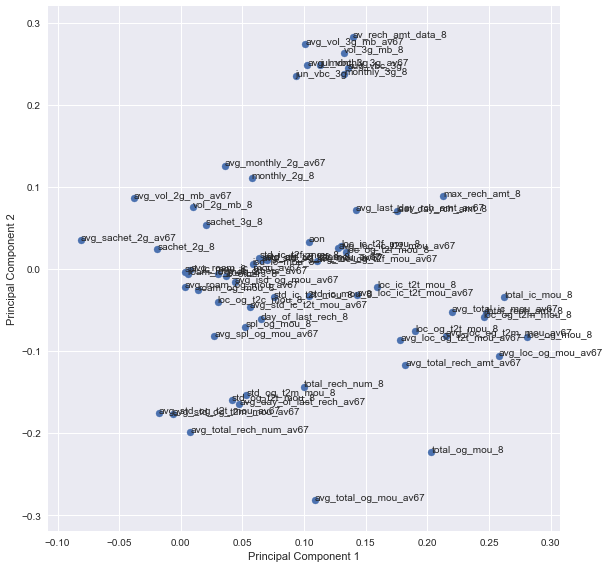

In [409]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

We see that the fist component is in the direction where the 'charges' variables are heavy
 - These 3 components also have the highest of the loadings

#### Looking at the screeplot to assess the number of needed principal components

In [410]:
pca.explained_variance_ratio_

array([1.06672190e-01, 8.69479189e-02, 6.05250597e-02, 5.30361118e-02,
       4.37590967e-02, 3.96922606e-02, 3.50694124e-02, 3.12255403e-02,
       2.98570261e-02, 2.78596412e-02, 2.70446204e-02, 2.58988855e-02,
       2.38126977e-02, 2.30631855e-02, 2.27118053e-02, 2.06007394e-02,
       1.90746661e-02, 1.82647208e-02, 1.65822070e-02, 1.60471669e-02,
       1.54308246e-02, 1.51241754e-02, 1.44696119e-02, 1.40801228e-02,
       1.31260239e-02, 1.26261206e-02, 1.18143993e-02, 1.12064652e-02,
       1.06214466e-02, 9.96643889e-03, 9.44098434e-03, 8.80860395e-03,
       8.52778384e-03, 8.19634171e-03, 7.88361620e-03, 7.57160879e-03,
       6.61565133e-03, 6.51352292e-03, 6.07529788e-03, 5.82444477e-03,
       5.63243037e-03, 5.50524423e-03, 5.42691375e-03, 4.54436514e-03,
       4.34083490e-03, 4.23104728e-03, 4.15991491e-03, 4.00672044e-03,
       3.87512764e-03, 3.60954031e-03, 3.47392225e-03, 3.13054979e-03,
       3.07809224e-03, 2.84580417e-03, 2.61876473e-03, 2.36947933e-03,
      

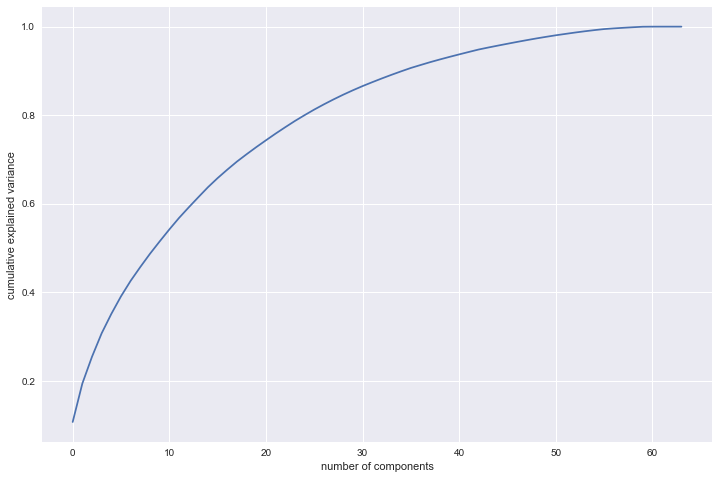

In [411]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#### Looks like 40 components are enough to describe 95% of the variance in the dataset
- We'll choose 40 components for our modeling

In [412]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=40)

#### Basis transformation - getting the data onto our PCs

In [413]:
df_train_pca = pca_final.fit_transform(X_tr)
df_train_pca.shape

(38618, 40)

#### Creating correlation matrix for the principal components - we expect little to no correlation

In [414]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

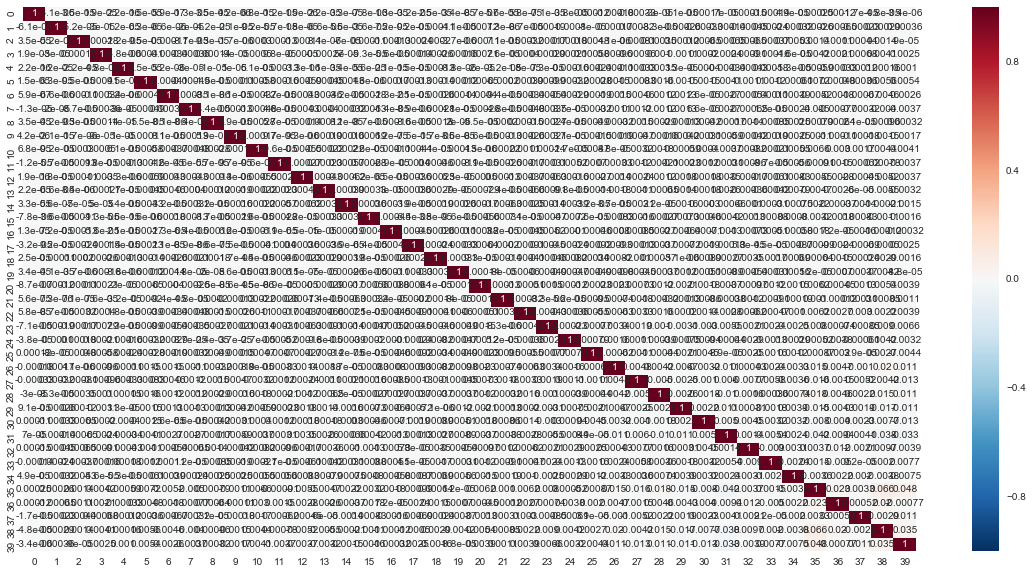

In [415]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)
plt.show()

In [416]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.06582150150957941 , min corr:  -0.042358404079364045


#### Observation - there is no correlation between any two components
- We effectively have removed multicollinearity from our situation, and our models will be much more stable

In [417]:
X_test.head()

,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,spl_og_mou_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,day_of_last_rech_8,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_total_og_mou_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2f_mou_av67,avg_total_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_day_of_last_rech_av67
0,-0.192836,-0.263903,-0.273541,-0.520634,-0.179412,-0.250023,-0.509719,-0.372047,-0.377235,-0.033120,-0.160175,-0.569587,-0.360376,0.365965,-0.200070,-0.123090,-0.287720,-0.421825,-0.220632,-0.171215,-0.095767,-0.437248,-0.210853,0.135982,0.591416,-0.473381,-0.264181,-0.295676,-0.285426,-0.345735,-0.281724,-0.155931,-0.424639,-0.316095,-0.355166,-0.357526,-2.660081,-0.222584,-0.290132,-0.355976,-0.533681,-0.115884,-0.578057,-0.473184,-0.498391,-0.116716,-0.063005,-0.290987,-0.873714,-0.372707,-0.000734,-0.011653,0.032503,-0.517072,-0.096110,-0.076950,0.124630,-0.041708,-0.408058,-0.385101,-0.407679,-0.485746,-0.382873,0.559878
1,-0.158708,-0.217931,-0.302377,-0.596103,-0.292040,0.192445,-0.581521,-0.365612,-0.394120,-0.136975,-0.182925,-0.610492,-0.334767,-0.327419,0.095276,-0.123090,-0.174109,-0.508747,-0.220632,-0.171215,-0.095767,-0.085464,-0.598847,-0.559594,-0.487653,-0.025041,0.458268,-0.295676,-0.285426,0.658594,-0.281724,0.993035,-0.351297,-0.316095,-0.355166,-0.357526,0.113856,-0.190348,-0.227023,-0.350284,-0.637886,-0.229708,-0.652808,-0.476528,-0.513228,-0.166668,-0.063005,0.619721,-0.899876,-0.160478,-0.337107,-0.203801,-0.149298,-0.642010,-0.096110,-0.137169,-1.029180,-0.708723,0.461859,-0.385101,-0.407679,2.026937,-0.382873,0.694574
2,-0.192836,-0.263903,0.580789,2.923049,-0.119432,1.377221,2.217870,-0.161102,0.195066,0.936956,0.339067,1.149139,-0.126549,0.101114,-0.019856,0.537325,0.112880,0.935184,-0.220632,-0.166613,-0.087415,0.031798,0.594845,0.288521,0.486507,-0.473381,-0.264181,-0.295676,-0.285426,-0.345735,-0.281724,-0.155931,-0.926570,-0.316095,-0.325715,-0.107246,0.483715,-0.222584,-0.290132,0.898299,2.763011,-0.150322,2.379588,-0.375849,-0.339704,0.159040,-0.063005,0.035353,0.651121,0.133316,-0.103210,-0.096855,0.114747,0.699630,-0.054794,-0.257605,0.424031,0.482056,-0.404305,1.083447,-0.407679,-0.485746,0.610023,0.021098
3,-0.192836,-0.263903,0.329579,0.271600,-0.292040,-0.250023,0.360473,-0.369244,-0.209883,-0.136975,-0.355447,-0.080596,-0.187881,-0.266114,-0.173487,-0.087323,-0.268678,0.036211,-0.220632,-0.171215,-0.095767,1.790721,0.152672,-0.437563,-0.262847,-0.473381,-0.264181,-0.295676,-0.285426,-0.345735,-0.281724,-0.155931,0.199910,-0.316095,-0.355166,-0.343903,1.038502,-0.222584,-0.290132,-0.079428,0.303759,-0.093299,0.150537,-0.450664,-0.285525,-0.166668,-0.063005,-0.234007,-0.389338,0.040121,-0.109996,-0.061490,0.087110,0.382174,-0.096110,0.946761,-0.259294,-0.668433,-0.408058,-0.385101,-0.407679,-0.485746,-0.382873,1.098659
4,0.153902,0.097967,-0.318717,-0.582647,-0.292040,-0.250023,-0.582978,-0.342647,-0.394120,-0.136975,-0.355447,-0.602648,-0.379624,-0.327419,-0.200070,-0.123090,-0.320883,-0.482335,-0.220632,0.034657,-0.095767,-0.671772,-0.546415,-0.071470,-0.487653,-0.473381,-0.264181,-0.295676,-0.285426,-0.345735,-0.281724,-0.155931,0.603288,-0.260260,4.129671,2.889

In [418]:
#Applying selected components to the test data - 40 components
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(9001, 40)

## Applying a logistic regression on our Principal Components


In [419]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca,y_tr)

In [420]:
#Making prediction on the train data
pred_probs_train = model_pca.predict_proba(df_train_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_tr, pred_probs_train))

'0.9'

In [421]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.88'

#### Observation: 
    The AUC obtained on the train data (balanced data set) is 0.90
    The AUC obtained on the test data is 0.88
    Therefore we can conclude that the model generalizes well on the unseen test data wiht 40 Principal Components

In [422]:
predictions_train = model_pca.predict(df_train_pca)

In [423]:
print(confusion_matrix(y_tr,predictions_train))

[[15696  3613]
 [ 2774 16535]]


In [424]:
"{:2.2}".format(metrics.accuracy_score(y_tr, predictions_train))

'0.83'

In [425]:
predictions_test = model_pca.predict(df_test_pca)

In [426]:
print(confusion_matrix(y_test,predictions_test))

[[6773 1478]
 [ 135  615]]


In [427]:
"{:2.2}".format(metrics.accuracy_score(y_test, predictions_test))

'0.82'

#### Observation: 
    The accuracy obtained on the train data is 0.83
    The accuracy obtained on the test data is 0.82

In [434]:
# Creating a data frame to hold the ground truth 'churn' and the predicted probability for the imbalanced training dataset
pca_y_train_pred_final = pd.DataFrame(list(zip(y_tr.tolist(), pred_probs_train.tolist())),
              columns=['churn','churn_prob'])

In [429]:
# Creating a data frame to hold the ground truth 'churn' and the predicted probability for the testing dataset
pca_y_test_pred_final = pd.DataFrame(list(zip(y_test.tolist(), pred_probs_test.tolist())),
              columns=['churn','churn_prob'])

In [435]:
fpr, tpr, thresholds = metrics.roc_curve(pca_y_train_pred_final.churn, pca_y_train_pred_final.churn_prob, drop_intermediate = False )

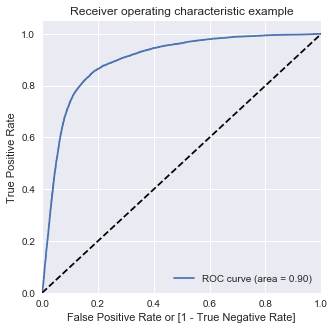

In [436]:
draw_roc(pca_y_train_pred_final.churn, pca_y_train_pred_final.churn_prob)

In [432]:
fpr, tpr, thresholds = metrics.roc_curve( pca_y_test_pred_final.churn, pca_y_test_pred_final.churn_prob, drop_intermediate = False )

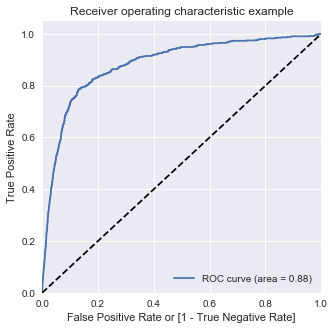

In [433]:
draw_roc(pca_y_test_pred_final.churn, pca_y_test_pred_final.churn_prob)

#### Precision, Recall , Accuracy and Specificity on the test set across various probability threshold values

In [437]:
# Let's create columns with different probability cutoffs on the test set
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    pca_y_test_pred_final[i]= pca_y_test_pred_final.churn_prob.map(lambda x: 1 if x > i else 0)
pca_y_test_pred_final.head()

,churn,churn_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.861783,1,1,1,1,1,1,1,1,1,0
1,1,0.568246,1,1,1,1,1,1,0,0,0,0
2,0,0.151818,1,1,0,0,0,0,0,0,0,0
3,0,0.218997,1,1,1,0,0,0,0,0,0,0
4,1,0.678507,1,1,1,1,1,1,1,0,0,0


In [438]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci', 'preci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(pca_y_test_pred_final.churn, pca_y_test_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    preci = cm1[1,1]/(cm1[1,1]+cm1[0,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci, preci]
print(cutoff_df)

     prob  accuracy     sensi     speci     preci
0.0   0.0  0.083324  1.000000  0.000000  0.083324
0.1   0.1  0.451505  0.960000  0.405284  0.127955
0.2   0.2  0.596267  0.929333  0.565992  0.162927
0.3   0.3  0.691479  0.898667  0.672646  0.199704
0.4   0.4  0.764693  0.852000  0.756757  0.241497
0.5   0.5  0.820798  0.820000  0.820870  0.293837
0.6   0.6  0.861015  0.785333  0.867895  0.350804
0.7   0.7  0.892901  0.701333  0.910314  0.415482
0.8   0.8  0.909899  0.557333  0.941946  0.465998
0.9   0.9  0.922564  0.302667  0.978912  0.566085


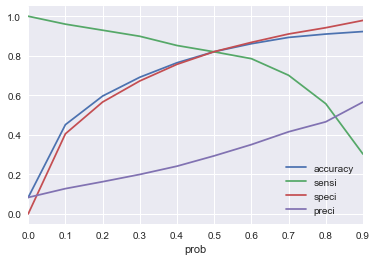

In [439]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci', 'preci'])
plt.show()

#### Comparing the Logistic Regression Model with the Random Forest Model:
The AUC, Precision and Recall values obtained on the logistic Regression model are much lower at similar threshold values than the Random Forest model

#### Summary:

1) Random Forest is a good method to predict Churn followed by Logistic regression using PCA  (Based on comaprison of AUC's, Precision, Recall values on the test set)  
2) Behaviour of the customer especially Roaming customers in the action phase is a good predictor for predicting Churn. Based on EDA and feature importance obtained during the modeling phase, Roaming seems to have a postive correlation on Churn  
3) Recommendation: The telecom company should provide better offers for customers that are frequently on Roaming. 


### Model Building Results:  
SMOTE was used to address the class imbalance prior to building the models
#### Random Forest:  
The AUC obtained on the Training set (balanced) is 0.98  
The AUC obtained on the Training set (imbalanced) is 0.94  
The AUC obtained on the Testing set is 0.93  
Therefore we can conclude that the model generalizes well on the unseen test data   

#### Analysis on Threshold value selection for Random Forest model:  
1) If the business objective is to identify maximum churn we can use a lower threshold value which could be 0.4 which give a recall value of 81% with a 39% precision.  
2) If the business objective is to maximise the precision than we can use a higher threshold value which could be 0.7 which give a precision of 63% with a recall value of 63%

Feature Importance: Based on the feature importances obtained using the Random Forest algorithm roam_og_mou_8, roam_ic_mou_8, total_ic_mou_8, day_of_last_rech_8, total_rech_amt_8 are important predictors to predict Churn  

#### Logistic regression with 40 Principal Components:  
The AUC obtained on the train data (balanced dataset) is 0.90   
The AUC obtained on the test data is 0.88    
Therefore we can conclude that the model generalizes well on the unseen test data with 40 Principal Components   
Based on the Prinicpal Component analysis roam_og_mou_8, roam_ic_mou_8 seem to be the most important predcitors that captures the most variance and very good predictors for predicting Churn